# GlobAlbedo and associated algorithms

P. Lewis and M. van Leeuwen, UCL/NCEO

Here, we explore variations on the theme of the ESA GlobAlbedo algorithm.

This first notebook deals with downloading the data from the database and constructing suitable data structures.

In [1]:
import pylab as plt
import numpy as np
%matplotlib inline
from glob import glob
import pandas as pd
import netCDF4
from netCDF4 import Dataset
import urllib2
from HTMLParser import HTMLParser
import os
import pickle
import kernels
import datetime
from datetime import date,timedelta



db = 'http://gws-access.cems.rl.ac.uk/public/globalbedo/.stackXY2/'

ImportError: No module named kernels

In [2]:
'''
Codes to pull netcdf files from the server

'''
# create a subclass and override the handler methods
class MyHTMLParser(HTMLParser):
    # see https://docs.python.org/2/library/htmlparser.html
    def handle_starttag(self, tag, attrs):
        pass;
        #print "Encountered a start tag:", tag
    def handle_endtag(self, tag):
        pass
        #print "Encountered an end tag :", tag
    def handle_data(self, data):
        data = data.strip()
        if len(data) and data[-1] == '/':
            # is it a directory?
            try:
                self.datadirs.append(data)
            except:
                self.datadirs = [data]
        if len(data) and data.split('.')[-1] == 'nc':
            # is it a nc file?
            try:
                self.ncfiles.append(data)
            except:
                self.ncfiles = [data]            
        
def getdirs(db):
    # get directories from url
    response = urllib2.urlopen(db,None,120)
    
    parser = MyHTMLParser()
    html = response.read()
    del response
    parser.feed(html)
    return parser

def nc_urls(db):
    '''
    obtain full list of data urls of nc files
    '''
    ncfiles = {}
    parser = getdirs(db)
    for sensor in parser.datadirs:
        ncfiles[sensor] = []
        parser2 = getdirs(db+sensor)
        if hasattr(parser2, 'datadirs'):
            for sub0 in parser2.datadirs:
                parser3 = getdirs(db+sensor+sub0)
                if hasattr(parser3, 'datadirs'):
                    for sub1 in parser3.datadirs:
                        parser4 = getdirs(db+sensor+sub0+sub1)
                        if hasattr(parser4, 'datadirs'):
                            print 'deepest level checked'
                        if hasattr(parser4, 'ncfiles'):
                            for nc in parser4.ncfiles:
                                ncfiles[sensor].append(db+sensor+sub0+sub1+nc)
                if hasattr(parser3, 'ncfiles'):
                    for nc in parser3.ncfiles:
                            ncfiles[sensor].append(db+sensor+sub0+nc)
        if hasattr(parser2, 'ncfiles'):
            for nc in parser2.ncfiles:
                ncfiles[sensor].append(db+sensor+nc)
    return ncfiles

def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(d):
        os.makedirs(d)
        
def obtain_data(db,doit=True):
    print 'connecting to',db
    ncfiles = nc_urls(db)
    print 'got urls'
    nclocals = {}
    datakeys = ncfiles.keys()
    for k in datakeys:
        print k
        ensure_dir(k)
        nclocals[k] = []
        for ncfile in ncfiles[k]:
            print '.',
            if doit:
                data = urllib2.urlopen(ncfile).read()
            local = ncfile.split('/')[-1]
            nclocals[k].append(local)
            # write
            if doit:
                f = open(k+local,'wb')
                f.write(data)
                f.close()
    for k in nclocals.keys():
        if k[-1] == '/':
            nclocals[k.strip('/')] = nclocals[k]
            del nclocals[k]
    return nclocals

In [2]:
'''
Contact the server for a listing and 
if doit is True download the files and pack into
the dictionary ncfiles. 

Actually, all we really need (to access pre-stored pickle files)
is to set the variable  `datakeys`
'''

doit = False
# set True if you want to download as well

if doit:
    ncfiles = obtain_data(db,doit=doit)
    datakeys = ncfiles.keys()
else:
    # this is most of them
    datakeys = np.array(['bbdr.flags', 'bbdr.meris', 'bbdr.vgt', 'ga.brdf.merge',\
       'ga.brdf.nosnow', 'ga.brdf.snow', 'mod09', 'myd09',\
       'prior.v2.nosnow', 'prior.v2.snow', 'prior.v2.snownosnow'])
#        'prior.v1.nosnow', 'prior.v1.snow1', 'prior.v1.snow2',\

print np.sort(datakeys)

['bbdr.flags' 'bbdr.meris' 'bbdr.vgt' 'ga.brdf.merge' 'ga.brdf.nosnow'
 'ga.brdf.snow' 'mod09' 'myd09' 'prior.v2.nosnow' 'prior.v2.snow'
 'prior.v2.snownosnow']


In [77]:

def save_obj(obj, name ):
    ensure_dir('obj/')
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
ncdata = {}

# the integer specifies how many _ fields to include
# eg var/covar are functions of band and kernel so 4 variables, so 5
specials = {
    'Data_Mask_':2,
    'Cov_':5,
    'Mean_':2,
    'VAR_':5,
    'mean_':3,
    'BB_':2,
    'sig_BB_':4,
    'Kgeo_BRDF':3,
    'Kvol_BRDF':3,
    'Kiso_BRDF':3
}

for k in datakeys:
    k = k.strip('/')
    ncdata[k] = {}
    print k
    try:
        ncdata[k] = load_obj(k)
    except:
        for i in xrange(len(ncfiles[k])):
            ncfile = Dataset(k+'/'+ncfiles[k][i],'r')         
            for kk in np.sort(ncfile.variables.keys()):
                # different data keys in different prior versions    
                for terms in ['MEAN__BAND________']:
                    if thiskey[:len(terms)] == terms:
                        thiskey = 'MEAN_BAND_'+thiskey.split(terms)[1:]
                        # eg 0_PARAMETER_F0_0000001_000000
                        
                # default
                thiskey = kk.split('_1_')[0]
                
                # check if its in the specials
                for terms in specials.keys():
                    if thiskey[:len(terms)] == terms:
                        thiskey = '_'.join(kk.split('_')[:specials[terms]])

                # time - specific examples for hooks into time field
                for terms in ['Cov_NIR_f0_NIR_f0','VAR_NIR_f0_NIR_f0','BB_NIR',\
                             'MODIS_Grid_1km_2D_Data_Fields_Range']:
                    if thiskey[:len(terms)] == terms:
                        doy = int(kk.split('_')[-2])
                        if ('doy' not in ncdata[k]):
                            print 'TIME'
                            ncdata[k]['doy'] = []
                        ncdata[k]['doy'].append(doy)
                    
                # other quite special ones, but all of a pattern
                # e.g. Snow_Fraction_XXX -> Snow_Fraction
                for terms in ['Snow_Fraction','Goodness_of_Fit','cloud_classif_flags','aot_flags',\
                             'snow_mask','RAA','SZA','VZA']:
                    # prior
                    nn = terms.count('_') + 1
                    if thiskey[:len(terms)] == terms:
                        thiskey = '_'.join(kk.split('_')[:nn]) 

                        

                # ignore these ones
                dontdoit = False
                for terms in ['Weighted_Number_of_Samples', 'Entropy', 'lat', 'lon',\
                             'Goodness_of_Fit','Relative_Entropy','Time_to_the_Closest_Sample',\
                             'AOD550','DEM','NDVI','SM','sig_AOD550','sig_NDVI',\
                             'Proportion_NSamples','l1_flags',\
                              'MODIS_Grid_1km_2D_Data_Fields_num_observations_1km',\
                             'MODIS_Grid_500m_2D_Data_Fields_num_observations_500m']:
                    nn = terms.count('_') + 1
                    if thiskey[:len(terms)] == terms:
                        dontdoit = True
                        thiskey = '_'.join(kk.split('_')[:nn]) 

                if not dontdoit:
                    if (thiskey not in ncdata[k]):
                        print k,thiskey,";",
                        ncdata[k][thiskey] = []
                    # read the data
                    thisdata = ncfile.variables[kk][:]
                    ncdata[k][thiskey].append(thisdata)
            del ncfile
        save_obj(ncdata[k],k)
        


bbdr.flags
bbdr.meris
bbdr.vgt
ga.brdf.merge
ga.brdf.nosnow
ga.brdf.snow
mod09
myd09
prior.v2.nosnow
prior.v2.snow
prior.v2.snownosnow


In [78]:
# sort doys
for k in ncdata.keys():
    print k,
    # prior has doy only
    if k[:5] != 'prior' and ('doy' in ncdata[k].keys()):
        print '\tdate'
        ncdata[k]['date'] = np.atleast_1d(np.zeros(0))
        ncdata[k]['yeardoy'] = np.array([ [int(str(i)[:4]),int(str(i)[4:])] for i in ncdata[k]['doy']])
        for year,doy in ncdata[k]['yeardoy']:
            ncdata[k]['date'] = np.append(ncdata[k]['date'],\
                                          datetime.date(year, 1, 1) + datetime.timedelta(days=doy))
    else:
        print 

mod09 	date
myd09 	date
bbdr.vgt 	date
ga.brdf.snow 	date
bbdr.flags
prior.v2.snow
prior.v2.snownosnow
ga.brdf.nosnow 	date
prior.v2.nosnow
bbdr.meris 	date
ga.brdf.merge 	date


## Modis QA mask



The MODIS QA mask for this product is specified on the [USGS site](https://lpdaac.usgs.gov/dataset_discovery/modis/modis_products_table/mod09a1).

The 32bit unsigned varaible `MOD09A1.005 500-meter Surface Reflectance Data QA Descriptions` identifies the following bit fields:

`[0,1],[2,5],[6,9],[10,13],[14,17],[18,21],[22,25],[26,29],[30,30],[31,31]]`

where each pair indicates the first and last significant bit of the relevant bitfield.

We need to form a mask of each of these, where the bits in the mask are set to `1` over the bit range indicated and `0` elsewhere. Python code to explore such things can be found in [Lewis (2016)](http://nbviewer.jupyter.org/github/profLewis/geogg122/blob/master/Chapter2_Python_intro/advanced.ipynb).

If $i$ and $j$ are the minimum and maximum bits of a particular bitfield, then, we calculate the number of bits involved 

$$
l = j - i
$$

The mask then is given by:

$$
2^{(l+1)}-1 << i
$$

where $<<$ is a left bitshift operation.

For example:

In [79]:
maskbits = np.array([[0,1],[2,5],[6,9],[10,13],[14,17],[18,21],[22,25],[26,29],[30,30],[31,31]])

# some test values to decode
test = np.array([1002159035,1107296257,1073741824]).astype(np.uint32).T

# initial size 0 array
modmask = np.atleast_1d(np.zeros(0)).astype(np.uint32)

for t in test[0:2]:
    print 'data',bin(t)
    for minbit,maxbit in maskbits:
        l = maxbit-minbit
        if l == 3:
            # 4 bit fields: reflectance quality
            modmask = np.append(modmask,(2**(l+1)-1 << minbit))
            print '\tmask',l,bin(modmask[-1]),(t & modmask[-1]) >> minbit
  

data 0b111011101110111011101110111011
	mask 3 0b111100 14
	mask 3 0b1111000000 14
	mask 3 0b11110000000000 14
	mask 3 0b111100000000000000 14
	mask 3 0b1111000000000000000000 14
	mask 3 0b11110000000000000000000000 14
	mask 3 0b111100000000000000000000000000 14
data 0b1000010000000000000000000000001
	mask 3 0b111100 0
	mask 3 0b1111000000 0
	mask 3 0b11110000000000 0
	mask 3 0b111100000000000000 0
	mask 3 0b1111000000000000000000 0
	mask 3 0b11110000000000000000000000 8
	mask 3 0b111100000000000000000000000000 0


where we see that for the 4-bit fields (band quality) `14` (that appears often in the first test) corresponds to `0b1110` which is interpreted as `L1B data faulty`.

Similarly, `0` (that appears often in the second test) corresponds to `0b0000` which means `highest quality`. The `8` value (`0b1000`) means `dead detector; data interpolated in L1B`.

The QA information we use will be to allow `0b0000` and `0b1000` fields to pass. If, for any waveband, the QA is not one of these, we reject the data.

We also reject data that does not have a full clearance on bits 0, 30 and 31.

In [80]:
def good_qa(t,good4=[0,8]):
    maskbits = np.array([[0,1],[2,5],[6,9],[10,13],[14,17],[18,21],[22,25],[26,29],[30,30],[31,31]])
    t = np.uint32(t)
    for minbit,maxbit in maskbits:
        l = maxbit-minbit
        if l == 3:
            # all of the 4 bit ones
            modmask = (2**(l+1)-1 << minbit)
            decode = (t & modmask) >> minbit
            if decode not in good4:
                return False
        if minbit == 0:
            # special case 1
            modmask = (2**(l+1)-1 << minbit)
            decode = (t & modmask) >> minbit
            if decode > 0:
                return False
        if minbit > 30:
            # special case 2,3
            modmask = (2**(l+1)-1 << minbit)
            decode = (t & modmask) >> minbit
            if decode > 0:
                return False
    return True

def modis_qa(tt,good4=[0,8]):
    # work on array
    tt = np.array(tt)
    out = np.ones_like(tt).astype(bool)
    for i,t in enumerate(tt):
        out[i] = good_qa(t,good4=good4)
    return out
        
print modis_qa([1002159035,1107296257,1073741824])

[False False  True]


For the QA field `MODIS_Grid_1km_2D_Data_Fields_state_1km` we take a similar approach:

In [81]:

def good_qa2(t,snow=False):
    t = np.uint16(t)
    retval = True
    
    maskbits = np.array([[0,1],[2,2],[3,5],[6,7],[8,9],[10,10],[11,11],[12,12],[13,12],[14,14],[15,15]])
    # cloud, cirrus, shadow, adj
    passers = np.array([0,2,8,13])

    for minbit,maxbit in maskbits:
        l = maxbit-minbit
        if minbit in passers:
            # special cases
            modmask = (2**(l+1)-1 << minbit)
            decode = (t & modmask) >> minbit
            if decode > 0:
                retval = False
            
        snowed = False
        #if minbit in [12,15]:
        if minbit in [15]:
            # snow tests
            modmask = (2**(l+1)-1 << minbit)
            decode = (t & modmask) >> minbit
            if decode == 1:
                snowed = True    
    
    return retval and ((snow and snowed) or (not snow and not snowed))

def modis_qa2(tt,snow=False):
    # work on array
    tt = np.array(tt)
    out = np.ones_like(tt).astype(bool)
    for i,t in enumerate(tt):
        out[i] = good_qa2(t,snow=snow)
    return out

test2 = np.array([8394, 1033, 1801])
print modis_qa2(test2,snow=False)

[False False False]


## narrow to broadband conversion

We use linear equatiuons of the form:

$$
B = w^T b
$$

where vector $B$ has 3 broad wavebands, $b$ is a vector of the 7 MODIS bands, and $w$ is the weighting matrix.

We also have an uncertainty matrix for the MODIS observations, following Roy et al. (2005) RSE 97: 137-162.

We use the narrow to broadband coefficients of [Liang, 2000](https://www.google.co.uk/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=0ahUKEwiOzKrEvYzLAhVBURoKHd7ECxIQFggiMAA&url=http%3A%2F%2Fterpconnect.umd.edu%2F~sliang%2Fpapers%2FRSE.N2B.1.pdf&usg=AFQjCNFDnawdSlcNvMTkNTSdSr447wfbnA&sig2=7SFNU8MS65X9aaVBtv30ow)

In [82]:
# compute modis weights from Roy et al. (2005) RSE 97: 137-162
modissd = np.array([0.004, 0.015, 0.003, 0.004, 0.013, 0.010, 0.006])

RI = np.matrix(np.diag(modissd*modissd)).I

bands = ['VIS','NIR','SW']

# modis narrow to broadband coefficients from Liang, 2000
BBweights = np.array([[0.331,0.000, 0.424,0.246,0.000,0.000,0.000, 0.0000],\
                      [0.039,0.504,-0.071,0.105,0.252,0.069,0.101, 0.0000],\
                      [0.160,0.291, 0.243,0.116,0.112,0.000,0.081,-0.0015]])

BBweights = np.array([[0.331,0.000, 0.424,0.246,0.000,0.000,0.000, 0.0000],\
                      [0.039,0.504,-0.071,0.105,0.252,0.069,0.101, 0.0000],\
                      [0.160,0.291, 0.243,0.116,0.112,0.000,0.081,-0.0015]])

# renormalise
#BBweights = (BBweights.T / BBweights.sum(axis=1)).T

In [83]:
# form the subset of the weights matrix
H = np.matrix(BBweights[:,:-1]).T

# then the uncertainty (4x4 matrix) is
BBuncertainty_weight = (H.T * RI * H)
print  np.sqrt(1./BBuncertainty_weight)

[[ 0.00571616         nan  0.00777522]
 [        nan  0.01773337  0.05972455]
 [ 0.00777522  0.05972455  0.01018774]]


In [99]:
# sort MODIS data
for k in ncdata.keys():
    # MODIS processing
    #
    # reflectance observations
    monkey = 'MODIS_Grid_500m_2D_Data_Fields_sur_refl_b%02d'
    monkey1 = monkey%1
    if monkey1 in ncdata[k].keys():
        print k

        modiswt = 1./(modissd*modissd)
        print '\tobs:',k,len(ncdata[k][monkey1])
        ncdata[k]['reflectance'] = np.zeros((7,len(ncdata[k][monkey1])))
        ncdata[k]['weight'] = np.zeros((7,len(ncdata[k][monkey1])))
        for i in xrange(1,8):
            ncdata[k]['reflectance'][i-1,:] = np.array(ncdata[k][monkey%i]).squeeze().astype(float) * 0.0001
            ncdata[k]['weight'][i-1,:] = modiswt[i-1]
           
            # this thresholding is a temporary fix
            # the -ve values mess things up - should probably label as bad data    
            baddata = ncdata[k]['reflectance'][i-1,:] < 0
            #bigbaddata = np.vstack([baddata]*7)
            for i in xrange(1,8):
                ncdata[k]['weight'][i-1,:][baddata] = 0.0
                ncdata[k]['reflectance'][i-1,:][baddata] = 0


            # apply the linear model to the mean
            BBrefl = (np.dot(BBweights[:,:-1],ncdata[k]['reflectance']).T + BBweights[:,-1]).T
            # narrow to broadband
            for j in xrange(len(bands)):
                ncdata[k]['BB_%s'%bands[j]] = BBrefl[j]
            
            # uncertainty
            #BBweight = np.dot(BBweights[:,:-1],ncdata[k]['weight'])
            for b1,band1 in enumerate(bands):
                for b2,band2 in enumerate(bands):
                    if b2 <= b1:
                        term = 'weight_BB_%s_%s'%(band1,band2)
                        ncdata[k][term] = BBuncertainty_weight[b1,b2]

            # extract qa
            test = np.array(ncdata[k]['MODIS_Grid_500m_2D_Data_Fields_QC_500m']).squeeze()
            test2 = np.array(ncdata[k]['MODIS_Grid_1km_2D_Data_Fields_state_1km']).squeeze()
            ncdata[k]['mask'] = modis_qa(test,good4=[0,8])
            ncdata[k]['mask_snow'] = modis_qa2(test2,snow=True)
            ncdata[k]['mask_nosnow'] = modis_qa2(test2,snow=False)
            
            for m in ['mask','mask_snow','mask_nosnow']:
                ncdata[k][m][baddata] = False
            # obscov - use as a weighting term?
            ncdata[k]['obscov'] = 0.01*np.array(ncdata['mod09']['MODIS_Grid_500m_2D_Data_Fields_obscov_500m']).squeeze().astype(float)

            # angles
            vza = 0.01*np.array(ncdata[k]['MODIS_Grid_1km_2D_Data_Fields_SensorZenith']).squeeze().astype(float)
            sza = 0.01*np.array(ncdata[k]['MODIS_Grid_1km_2D_Data_Fields_SolarZenith']).squeeze().astype(float)
            vaa = 0.01*np.array(ncdata[k]['MODIS_Grid_1km_2D_Data_Fields_SensorAzimuth']).squeeze().astype(float)
            saa = 0.01*np.array(ncdata[k]['MODIS_Grid_1km_2D_Data_Fields_SolarAzimuth']).squeeze().astype(float)
            kern = kernels.Kernels(vza, sza, vaa-saa, doIntegrals=False, RossHS=False, RossType='Thick',\
                     LiType='Sparse', normalise=1, nbar=0., RecipFlag=True, MODISSPARSE=True)

            ncdata[k]['Kvol'],ncdata[k]['Kgeo'] = np.asarray(kern.Ross),np.asarray(kern.Li)



mod09
	obs: mod09 5727
myd09
	obs: myd09 4916


## Examine MODIS data

We can now examine the MODIS broad band reflectance data.

We can look in particular at whether the two formulae given by Liang for direct and diffuse effects make any real difference.

We can also examine the quality and quantity of snow and no snow data:

0.00571615965156
0.0177333662389
0.0101877402269


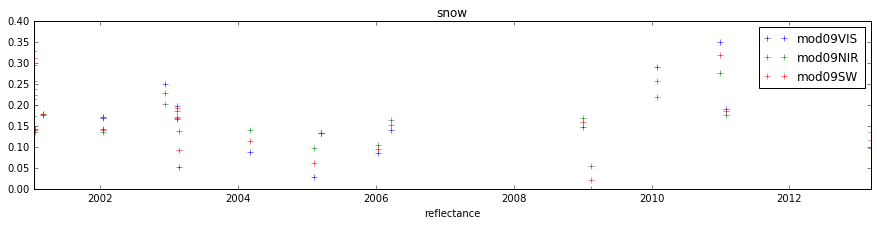

In [100]:
plt.figure(figsize=(15,3))
for mod in ['mod09']:
    for i in xrange(len(bands)):
        mm = ncdata[mod]['mask_snow']
        x = ncdata[mod]['date'][mm]
        y = ncdata[mod]['BB_%s'%bands[i]][mm]
        w = ncdata[mod]['weight_BB_%s_%s'%(bands[i],bands[i])]
        unc =  np.sqrt(1/w)
        print unc
        plt.plot(x,y,'+',label=mod+bands[i])
plt.xlabel('time')
plt.xlabel('reflectance')
plt.legend(loc='best')
plt.title('snow')

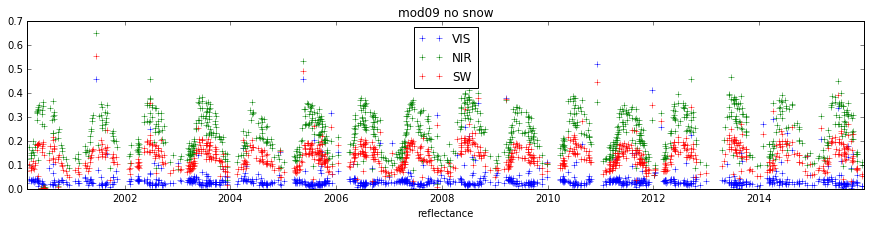

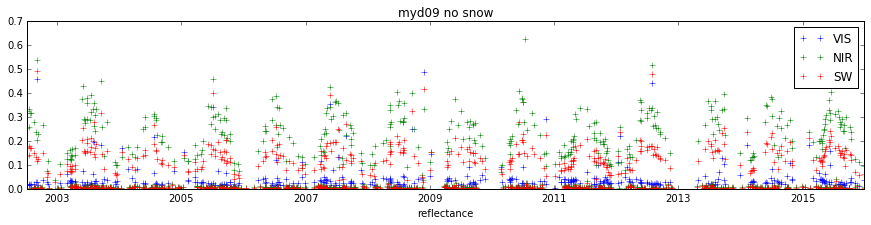

In [104]:
for m in ['mod09','myd09']:
    plt.figure(figsize=(15,3))
    for i in xrange(len(bands)):
        mm = ncdata[m]['mask_nosnow']
        x = ncdata[m]['date'][mm]
        y = ncdata[m]['BB_%s'%bands[i]][mm]
        plt.plot(x,y,'+',label=bands[i])
    plt.ylim(0,.7)
    plt.xlabel('time')
    plt.xlabel('reflectance')
    plt.legend(loc='best')
    plt.title('%s no snow'%m)



In [105]:
for m in ['mod09','myd09']:
    save_obj(ncdata[m], 'data_%s'%m )

In [106]:
for k in datakeys:
    k = k.strip('/')
    save_obj(ncdata[k], 'data_2_%s'%k )

In [108]:
!ls obj

bbdr.flags.pkl                 data_2_mod09.pkl               ga.brdf.snow.pkl
bbdr.meris.pkl                 data_2_myd09.pkl               mod09.pkl
bbdr.vgt.pkl                   data_2_prior.v2.nosnow.pkl     myd09.pkl
data_2_bbdr.flags.pkl          data_2_prior.v2.snow.pkl       prior.v1.nosnow.pkl
data_2_bbdr.meris.pkl          data_2_prior.v2.snownosnow.pkl prior.v1.snow2.pkl
data_2_bbdr.vgt.pkl            data_mod09.pkl                 prior.v2.nosnow.pkl
data_2_ga.brdf.merge.pkl       data_myd09.pkl                 prior.v2.snow.pkl
data_2_ga.brdf.nosnow.pkl      ga.brdf.merge.pkl              prior.v2.snownosnow.pkl
data_2_ga.brdf.snow.pkl        ga.brdf.nosnow.pkl
